In [1]:
import glob
import os
import sys
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from multiprocessing import Process
import gc

import tensorflow as tf
import sklearn
import time

import numpy as np
import pandas as pd
from pandas import DataFrame

#!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

2024-02-20 18:43:31.637378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 18:43:32.512130: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 18:43:33.814209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-20 18:43:33.814500: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
# argumentos
n = len(sys.argv)
print("Total arguments passed:", n)
iteracoes = 0
cycle_index = 1
finalIterations = 0
if(n > 0):
    for value in sys.argv:
        print("arg:", value)
        if("iterations=" in value):
            try:
                iteracoes = int(value.replace("iterations=",""))
            except:
                print("no")
        
        if("cycle=" in value):
            try:
                cycle_index = int(value.replace("cycle=",""))
            except:
                print("no")
print("iteracoes:",iteracoes)      
print("cycle:",cycle_index)

Total arguments passed: 3
arg: /home/guilherme/cpu-tensorflow-marcelo/nvidia-smi/envs/flower/lib/python3.9/site-packages/ipykernel_launcher.py
arg: -f
arg: /home/guilherme/.local/share/jupyter/runtime/kernel-36a66af6-17d4-45f7-9331-7e51e05a820b.json
iteracoes: 0
cycle: 1


In [3]:
# input folder
#inputFolders = "../02-transformed-data-new-testes/dados2019/"
inputFolderPath = "../data_2019_processed/"

# General configuration
NUMBER_OF_ITERATIONS_FINAL = 200
    
NUM_EPOCHS = 1
BATCH_SIZE = 32
VERBOSE = 0


# usado para checkpoints
if(iteracoes > 0):
    NUMBER_OF_ITERATIONS_FINAL = iteracoes
    
NUMBER_OF_ITERATIONS = NUMBER_OF_ITERATIONS_FINAL


# output folder
outputFolder = "result_unbalanced_epoch_"+str(NUM_EPOCHS)+"_rounds_"+str(NUMBER_OF_ITERATIONS_FINAL)+"_cycle_"+str(cycle_index)
#outputFolder = "test_checkpoint"
checkPointFolder = outputFolder+"/checkpoints"
iferredCycleDataFolder = outputFolder+"/inferred_datasets"

# train file name modifier
fileSufixTrain = "" # _smote for smote

#fl.common.logger.configure(identifier="myFlowerExperiment", filename="log_"+outputFolder+".txt")

In [4]:
print("Checking whether checkpoint exist")
print(checkPointFolder)
isExist = os.path.exists(checkPointFolder)
if not isExist:
    # Create a new directory because it does not exist
    print("There is no checkpoint available to continue the process!")
    sys.exit("There is no checkpoint available to continue the process!")

Checking whether checkpoint exist
result_unbalanced_epoch_1_rounds_200_cycle_1/checkpoints


In [5]:
print("Checking whether the data folder exists or not")
isExist = os.path.exists(iferredCycleDataFolder)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(iferredCycleDataFolder)
    print("The new directory is created! ",iferredCycleDataFolder)
else:
    print("The directory exists!")

Checking whether the data folder exists or not
The directory exists!


In [6]:
# selected features
inputFeatures = ["activity","location","day_of_week","light","phone_lock","proximity","sound","time_to_next_alarm", "minutes_day"]
outputClasses = ["awake","asleep"]
#outputClasses = ["class"]

In [7]:
# client datasets used on the training process (75% of data)
trainFolders =  ['0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs',
                '0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA', 
                '2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0', 
                '2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys', 
                #['5FLZBTVAPwdq9QezHE2sVCJIs7p+r6mCemA2gp9jATk'], #does not have the file
                '7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA', 
                'a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4', 
                'ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc', 
                'Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U', 
                'CH8f0yZkZL13zWuE9ks1CkVJRVrr+jsGdUXHrZ6YeA', 
                'DHO1K4jgiwZJOfQTrxvKE2vn7hkjamigroGD5IaeRc', 
                #'DHPqzSqSttiba1L3BD1cptNJPjSxZ8rXxF9mY3za6WA', # does not have asleep data
                'dQEFscjqnIlug8Tgq97JohhSQPG2DEOWJqS86wCrcY', 
                'HFvs2CohmhHte+AaCzFasjzegGzxZKPhkrX23iI6Xo', 
                'jgB9E8v3Z6PKdTRTCMAijBllA9YEMtrmHbe4qsbmJWw', 
                'JkY++R7E8myldLN3on6iQ78Ee78zCbrLuggfwGju3I', 
                'K4SLohf+TN1Ak8Dn8iE3Lme7rEMPISfppB2sXfHX8', 
                'oGaWetJJJEWHuvYdWYo826SQxfhCExVVQ2da8LE1Y7Q', 
                'pyt24oiDAHsmgWMvkFKz2fn2pwcHiXchd6KchLM', 
                #'PZCf1nfvhR+6fk+7+sPNMYOgb8BAMmtQtfoRS83Suc', # does not have asleep data
                'QUNCATForxzK0HHw46LrGOMWh0eVA8Y5XWEiUXX+cQ', 
                #'rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw', 
                #'RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI', 
                'SH3kQeyd5volraxw8vOyhlowNqWBPr1IJ9URNXUL4']
                #'VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is', 
                #'Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw', 
                #'XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA', 
                #'YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw', 
                #'ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM', 
                #'ZSsAZ0Pq+MCqFrnjsRFn5Ua09pMCVaOV9c8ZuYb7XQY']
            
# client datasets used on the training process (25% of data)
testFolders =  [#'0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs',
                #'0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA', 
                #'2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0', 
                #'2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys', 
                #['5FLZBTVAPwdq9QezHE2sVCJIs7p+r6mCemA2gp9jATk'], #does not have the file
                #'7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA', 
                #'a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4', 
                #'ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc', 
                #'Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U', 
                #'CH8f0yZkZL13zWuE9ks1CkVJRVrr+jsGdUXHrZ6YeA', 
                #'DHO1K4jgiwZJOfQTrxvKE2vn7hkjamigroGD5IaeRc', 
                #'DHPqzSqSttiba1L3BD1cptNJPjSxZ8rXxF9mY3za6WA', # does not have asleep data
                #'dQEFscjqnIlug8Tgq97JohhSQPG2DEOWJqS86wCrcY', 
                #'HFvs2CohmhHte+AaCzFasjzegGzxZKPhkrX23iI6Xo', 
                #'jgB9E8v3Z6PKdTRTCMAijBllA9YEMtrmHbe4qsbmJWw', 
                #'JkY++R7E8myldLN3on6iQ78Ee78zCbrLuggfwGju3I', 
                #'K4SLohf+TN1Ak8Dn8iE3Lme7rEMPISfppB2sXfHX8', 
                #'oGaWetJJJEWHuvYdWYo826SQxfhCExVVQ2da8LE1Y7Q', 
                #'pyt24oiDAHsmgWMvkFKz2fn2pwcHiXchd6KchLM', 
                #'PZCf1nfvhR+6fk+7+sPNMYOgb8BAMmtQtfoRS83Suc', # does not have asleep data
                #'QUNCATForxzK0HHw46LrGOMWh0eVA8Y5XWEiUXX+cQ', 
                'rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw', 
                'RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI', 
                #'SH3kQeyd5volraxw8vOyhlowNqWBPr1IJ9URNXUL4'] 
                'VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is', 
                'Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw', 
                'XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA', 
                'YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw', 
                'ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM', 
                'ZSsAZ0Pq+MCqFrnjsRFn5Ua09pMCVaOV9c8ZuYb7XQY']

In [8]:
def generateMetrics(y_test,yhat_probs):
    # predict crisp classes for test set deprecated
    #yhat_classes = model.predict_classes(X_test, verbose=0)
    #yhat_classes = np.argmax(yhat_probs,axis=1)
    yhat_classes = yhat_probs.round()
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, yhat_classes)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, yhat_classes)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, yhat_classes)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, yhat_classes)
    # kappa
    kappa = cohen_kappa_score(y_test, yhat_classes)
    # ROC AUC
    auc = roc_auc_score(y_test, yhat_probs)
    # confusion matrix
    matrix = confusion_matrix(y_test, yhat_classes)
    #print(matrix)
    
    array = []
    results = dict()
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1_score'] = f1
    results['cohen_kappa_score'] = kappa
    results['roc_auc_score'] = auc
    results['matrix'] = ("[[ " +str(matrix[0][0]) + " " +str(matrix[0][1]) +"][ " +str(matrix[1][0]) + " " + str(matrix[1][1]) +"]]") # array.append(np.array(matrix,dtype=object))
    results['TP'] = matrix[0][0]
    results['FP'] = matrix[0][1]
    results['FN'] = matrix[1][0]
    results['TN'] = matrix[1][1]
    
    array.append(accuracy)
    array.append(precision)
    array.append(recall)
    array.append(f1)
    array.append(kappa)
    array.append(auc)
    array.append("[[ " +str(matrix[0][0]) + " " +str(matrix[0][1]) +"][ " +str(matrix[1][0]) + " " + str(matrix[1][1]) +"]]") # array.append(np.array(matrix,dtype=object))
    array.append(matrix[0][0]) # TP
    array.append(matrix[0][1]) # FP
    array.append(matrix[1][0]) # FN
    array.append(matrix[1][1]) # TN
    
    return results, array

# y_test     = Array with real values
# yhat_probs = Array with predicted values
def printMetrics(y_test,yhat_probs):
    # generate metrics
    results, array= generateMetrics(y_test,yhat_probs)

    # accuracy: (tp + tn) / (p + n)
    accuracy = results['accuracy']
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = results['precision']
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = results['recall'] 
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = results['f1_score']
    print('F1 score: %f' % f1)
    # kappa
    kappa = results['cohen_kappa_score']
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = results['roc_auc_score']
    print('ROC AUC: %f' % auc)
    # confusion matrix
    print("\Confusion Matrix")
    matrix = results['matrix']
    print(matrix)
    
    return results, array

def generateGlobalMetrics(metrics):
    accuracy,precision,recall,f1_score,cohen_kappa_score,roc_auc_score = 0,0,0,0,0,0
    for metric in metrics:
        accuracy = accuracy + metric['accuracy']
        precision = precision + metric['precision']
        recall = recall + metric['recall']
        f1_score = f1_score + metric['f1_score']
        cohen_kappa_score = cohen_kappa_score + metric['cohen_kappa_score']
        roc_auc_score = roc_auc_score + metric['roc_auc_score']
        
    # mean
    size = len(metrics)
    print(size)
    accuracy = accuracy / size
    precision = precision / size
    recall = recall / size
    f1_score = f1_score / size
    cohen_kappa_score = cohen_kappa_score / size
    roc_auc_score = roc_auc_score / size
    
    return [accuracy,precision,recall,f1_score,cohen_kappa_score,roc_auc_score]

def showGlobalMetrics(metrics):
    res = generateGlobalMetrics(metrics)
    
    accuracy = res[0]
    precision = res[1]
    recall = res[2]
    f1_score = res[3]
    cohen_kappa_score = res[4]
    roc_auc_score = res[5]
    
    #show:\
    print("accuracy: ",accuracy)
    print("precision: ",precision)
    print("recall: ",recall)
    print("f1_score: ",f1_score)
    print("cohen_kappa_score: ",cohen_kappa_score)
    print("roc_auc_score: ",roc_auc_score)
    
    return res

In [9]:
# take the list of directories and concat them
def loadDataFromFolders(foldersToLoad,inputFolders,fileType = ""):
    print(len(foldersToLoad), "datasets")
    for i in range(0,len(foldersToLoad)):
        currentFolder = foldersToLoad[i]
        print(i , "-", currentFolder,inputFolders+"student_"+currentFolder+"_transformed"+fileType+".csv")
        #print(trainingDataSet[i])
        if(i == 0):
            temp_data = pd.read_csv(inputFolders+"student_"+currentFolder+"_transformed"+fileType+".csv")
        else:
            dataset = pd.read_csv(inputFolders+"student_"+currentFolder+"_transformed"+fileType+".csv")
            temp_data = pd.concat([temp_data, dataset])
    # return the dataset        
    return temp_data

# take the list of directories and concat them
def loadDataFromFoldersOnList(foldersToLoad,inputFolders,fileType = ""):
    clientList = []
    print(len(foldersToLoad), "datasets")
    for i in range(0,len(foldersToLoad)):
        currentFolder = foldersToLoad[i]
        print(i , "-", currentFolder,inputFolders+"student_"+currentFolder+"_transformed"+fileType+".csv")
        #print(trainingDataSet[i])
        temp_data = pd.read_csv(inputFolders+"student_"+currentFolder+"_transformed"+fileType+".csv")
        print("Adding to the list: ", temp_data.shape)
        clientList.append(temp_data)
    # return the dataset        
    return clientList

Load datasets

In [10]:
print("Preparing test data")
 
# test data comprising 25% of the data. It must be fixed to all models being evaluated
#X_test  = pd.read_csv(inputFolders+"test/allData-classification-numeric-normalized.csv")
X_test = loadDataFromFolders(testFolders,inputFolderPath,"")

print()
# undestand the dataset by looking on their infos
print(X_test.info())

X_test

Preparing test data
8 datasets
0 - rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw ../data_2019_processed/student_rIl2UK9+bQ+tzpFdbJAdbBxEa5GbgrgC030yEaENLw_transformed.csv
1 - RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI ../data_2019_processed/student_RoBW3cDOO9wWRMPO2twQff83MPc+OXn6gJ+a1DafreI_transformed.csv
2 - VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is ../data_2019_processed/student_VVpwFNMrEglveh6MDN8lrRzTy5OwzglD4FURfM4A2is_transformed.csv
3 - Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw ../data_2019_processed/student_Wa1mcNmbh66S7VS6GIzyfCFMD3SGhbtDQyFP1ywJEsw_transformed.csv
4 - XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA ../data_2019_processed/student_XCKRE0BWRHxfP1kZIihgtT+jUjSp2GE8v5ZlhcIhVmA_transformed.csv
5 - YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw ../data_2019_processed/student_YI5Y79K6GXqAUoGP6PNyII8WKlAoel4urDxWSVVOvBw_transformed.csv
6 - ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM ../data_2019_processed/student_ypklj+8GJ15rOIH1lpKQtFJOuK+VdvyCuBPqhY3aoM_transformed.csv


,activity,location,timestamp,time_to_next_alarm,sound,proximity,phone_lock,light,day_of_week,minutes_day,timestamp_text,class
0,0.75,1.0,0.000000e+00,0.000000,0.515992,1.0,0.0,0.000000,1.000000,0.678249,2018-05-14 16:16:08+00:00,awake
1,0.25,1.0,3.211282e-07,0.000000,0.542171,0.0,1.0,0.000007,1.000000,0.678944,2018-05-14 16:17:39+00:00,awake
2,0.25,1.0,6.422564e-07,0.000000,0.515992,0.0,1.0,0.000000,1.000000,0.679639,2018-05-14 16:18:39+00:00,awake
3,0.00,1.0,6.422564e-07,0.000000,0.515992,0.0,1.0,0.000000,1.000000,0.680334,2018-05-14 16:19:09+00:00,awake
4,0.25,1.0,6.422564e-07,0.000000,0.531341,0.0,1.0,0.000000,1.000000,0.681028,2018-05-14 16:20:09+00:00,awake
...,...,...,...,...,...,...,...,...,...,...,...,...
23747,0.25,1.0,5.819100e-03,0.000099,0.000000,1.0,1.0,0.000236,0.166667,0.510076,2018-06-13 12:14:37+00:00,awake
23748,0.25,1.0,5.819743e-03,0.000694,0.000000,1.0,1.0,0.000325,0.166667,0.512856,2018-06-13 12:18:08+00:00,awake
23749,0.25,1.0,5.819743e-03,0.000595,0.000000,1.0,1.0,0.000325,0.166667,0.513551,2018-06-13 12:19:08+00:00,awake
23750,0.25,1.0,5.820064e-03,0.000595,0.000000,1.0,1.0,0.000354,0.166667,0.513551,2018-06-13 12:19:38+00:00,awake


In [11]:
print("Preparing X_train data")
# load cliend data
clientList = loadDataFromFoldersOnList(trainFolders,inputFolderPath,fileSufixTrain)
        
NUMBER_OF_CLIENTS = len(clientList)
print("Total",(len(clientList)))

Preparing X_train data
19 datasets
0 - 0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs ../data_2019_processed/student_0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs_transformed.csv
Adding to the list:  (17993, 12)
1 - 0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA ../data_2019_processed/student_0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA_transformed.csv
Adding to the list:  (11561, 12)
2 - 2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0 ../data_2019_processed/student_2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0_transformed.csv
Adding to the list:  (3383, 12)
3 - 2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys ../data_2019_processed/student_2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys_transformed.csv
Adding to the list:  (19389, 12)
4 - 7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA ../data_2019_processed/student_7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA_transformed.csv
Adding to the list:  (2753, 12)
5 - a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4 ../data_2019_processed/student_a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP

In [12]:
# one-hot encoding function
def transform_output_nominal_class_into_one_hot_encoding(dataset):
    # create two classes based on the single class
    one_hot_encoded_data = pd.get_dummies(dataset['class'])
    #print(one_hot_encoded_data)
    dataset['awake'] = one_hot_encoded_data['awake']
    dataset['asleep'] = one_hot_encoded_data['asleep']
    
    return dataset

# one-hot encoding function
def transform_output_numerical_class_into_one_hot_encoding(dataset):
    # create two classes based on the single class
    one_hot_encoded_data = pd.get_dummies(dataset['class'])
    #print(one_hot_encoded_data)
    dataset['awake'] = one_hot_encoded_data[0]
    dataset['asleep'] = one_hot_encoded_data[1]
    
    return dataset

# transform output to one_hot_encoding for the testing dataset
X_test = transform_output_nominal_class_into_one_hot_encoding(X_test)

# transform output to one_hot_encoding for the input dataset
for i in range(0,len(clientList)):
    clientList[i] = transform_output_nominal_class_into_one_hot_encoding(clientList[i])
    #print (clientList[i])
    

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134888 entries, 0 to 23751
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   activity            134888 non-null  float64
 1   location            134888 non-null  float64
 2   timestamp           134888 non-null  float64
 3   time_to_next_alarm  134888 non-null  float64
 4   sound               134888 non-null  float64
 5   proximity           134888 non-null  float64
 6   phone_lock          134888 non-null  float64
 7   light               134888 non-null  float64
 8   day_of_week         134888 non-null  float64
 9   minutes_day         134888 non-null  float64
 10  timestamp_text      134888 non-null  object 
 11  class               134888 non-null  object 
 12  awake               134888 non-null  bool   
 13  asleep              134888 non-null  bool   
dtypes: bool(2), float64(10), object(2)
memory usage: 13.6+ MB


In [13]:
def transform_data_type(dataframe):
    
    # transform inputs
    for column in inputFeatures:
        dataframe[column] = dataframe[column].astype('float32')
    
    # transform outputs
    for column in outputClasses:
        dataframe[column] = dataframe[column].astype('float32')
    
    return dataframe

# transforms the data
X_test = transform_data_type(X_test)

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134888 entries, 0 to 23751
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   activity            134888 non-null  float32
 1   location            134888 non-null  float32
 2   timestamp           134888 non-null  float64
 3   time_to_next_alarm  134888 non-null  float32
 4   sound               134888 non-null  float32
 5   proximity           134888 non-null  float32
 6   phone_lock          134888 non-null  float32
 7   light               134888 non-null  float32
 8   day_of_week         134888 non-null  float32
 9   minutes_day         134888 non-null  float32
 10  timestamp_text      134888 non-null  object 
 11  class               134888 non-null  object 
 12  awake               134888 non-null  float32
 13  asleep              134888 non-null  float32
dtypes: float32(11), float64(1), object(2)
memory usage: 9.8+ MB


In [14]:
print("Prepering the test dataset")
# selects the data to train and test
X_test_data = X_test[inputFeatures]
y_test_label = X_test[outputClasses]

# transtorm data to tensor slices
#client_test_dataset = tf.data.Dataset.from_tensor_slices((X_test_data.values, y_test_label.values))

#client_test_dataset = client_test_dataset.repeat(NUM_EPOCHS).batch(BATCH_SIZE, drop_remainder=True)
#client_test_dataset = client_test_dataset.repeat(NUM_EPOCHS).batch(BATCH_SIZE)

#print(client_test_dataset.element_spec)
#client_test_dataset

Prepering the test dataset


--
--
Load model from checkpoint
--
--

In [15]:
print("creating model")

def create_keras_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(9,)),
      #tf.keras.layers.Dense(9, activation=tf.keras.activations.relu), 
      tf.keras.layers.Dense(16, activation=tf.keras.activations.relu),
      tf.keras.layers.Dense(8, activation=tf.keras.activations.relu),
      tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
      #tf.keras.layers.Dense(2, activation=tf.nn.sigmoid)
    ])

keras_model = create_keras_model()
#keras_model.summary()
keras_model.summary()

creating model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                160       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
Total params: 314
Trainable params: 314


2024-02-20 18:43:39.608451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-20 18:43:39.729440: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2024-02-20 18:43:39.729516: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-02-20 18:43:39.732530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

Non-trainable params: 0
_________________________________________________________________


In [16]:
# comment for the future: I should load the models thinking on:
# 1 - best global accuracy
# 2 - best model for each device (I should save the best model for each device)
# 3 - maybe I have to try use the metric roc

print("Loading checkpoint model",checkPointFolder+"/round-*")
list_of_files = [fname for fname in glob.glob(checkPointFolder+"/round-*")]
last_round_checkpoint = -1
latest_round_file = None
model_check_point = None
filename_h5 = None
filename_np = None

if len(list_of_files) > 0:
    valuesTempString = [value.replace(outputFolder+"/checkpoints/round-","").replace("-weights.h5","").replace("-weights.npz","") for value in list_of_files]
    if(len(valuesTempString) > 0):
        last_round_checkpoint = max([int(value) for value in valuesTempString])
        print("Loading pre-trained model from: ", last_round_checkpoint)
        # load the name
        print("Last round: ",last_round_checkpoint)
    
        filename_h5 = checkPointFolder+"/round-"+str(last_round_checkpoint)+"-weights.h5"
        filename_np = checkPointFolder+"/round-"+str(last_round_checkpoint)+"-weights.npz"
else:
    print("No checkpoint file found")
    sys.exit("No checkpoint file found")

Loading checkpoint model result_unbalanced_epoch_1_rounds_200_cycle_1/checkpoints/round-*
Loading pre-trained model from:  200
Last round:  200


In [17]:
# load model
# load checkpoint
print("load checkpoint")
keras_model.load_weights(filename_h5)

load checkpoint


In [18]:
#load file
predictedDF = []
# for each data infer the output and save the new value
print(len(trainFolders), "datasets")
for i in range(0,len(trainFolders)): 
    trainOne = clientList[i]
    currentFolder = trainFolders[i]
    outputFileName = iferredCycleDataFolder+"/student_"+currentFolder+".csv"
    # load data
    temp_data = pd.read_csv(outputFileName)

    predictedDF.append(temp_data)

    temp_data["awake"] = temp_data["awake"].astype(int)
    temp_data["asleep"] = temp_data["asleep"].astype(int)
    print()
    print(i,currentFolder)
    print("Count:  ",len(temp_data["awake"]), "   ",len(trainOne["awake"]))
    print("Awake:  ",sum(temp_data["awake"]), "  ",sum(trainOne["awake"]))
    print("Asleep: ",sum(temp_data["asleep"]),"  ",sum(trainOne["asleep"]))

19 datasets

0 0Jf4TH9Zzse0Z1Jjh7SnTOe2MMzeSnFi7feTnkG6vgs
Count:   17993     17993
Awake:   16465    16341
Asleep:  1528    1652

1 0tdmm6rwW3KquQ73ATYYJ5JkpMtvbppJ0VzA2GExdA
Count:   11561     11561
Awake:   8540    8158
Asleep:  3021    3403

2 2cyV53lVyUtlMj0BRwilEWtYJwUiviYoL48cZBPBq0
Count:   3383     3383
Awake:   1868    2064
Asleep:  1515    1319

3 2J22RukYnEbKTk7t+iUVDBkorcyL5NKN6TrLe89ys
Count:   19389     19389
Awake:   14913    16586
Asleep:  4476    2803

4 7EYF5I04EVqisUJCVNHlqn77UAuOmwL2Dahxd3cA
Count:   2753     2753
Awake:   2481    2426
Asleep:  272    327

5 a9Qgj8ENWrHvl9QqlXcIPKmyGMKgbfHk9Dbqon1HQP4
Count:   26567     26567
Awake:   18805    22241
Asleep:  7762    4326

6 ae4JJBZDycEcY8McJF+3BxyvZ1619y03BNdCxzpZTc
Count:   24534     24534
Awake:   20824    21466
Asleep:  3710    3068

7 Ch3u5Oaz96VSrQbf0z31X6jEIbeIekkC0mwPzCdeJ1U
Count:   33903     33903
Awake:   25971    29458
Asleep:  7932    4445

8 CH8f0yZkZL13zWuE9ks1CkVJRVrr+jsGdUXHrZ6YeA
Count:   26440    

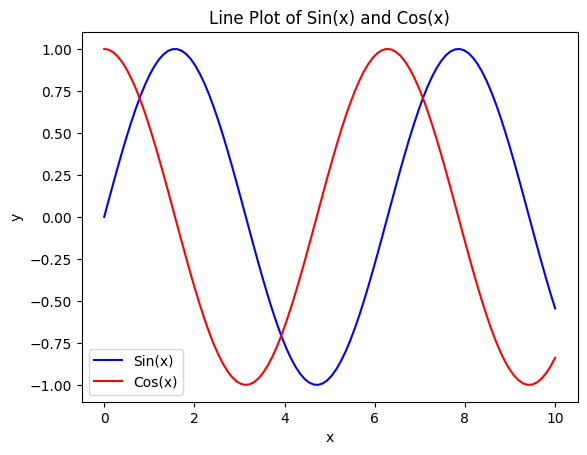

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)

# Create the line plot
plt.plot(x, y1, color='blue', label='Sin(x)')
plt.plot(x, y2, color='red', label='Cos(x)')

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Line Plot of Sin(x) and Cos(x)')

# Add legend
plt.legend()

# Show plot
plt.show()


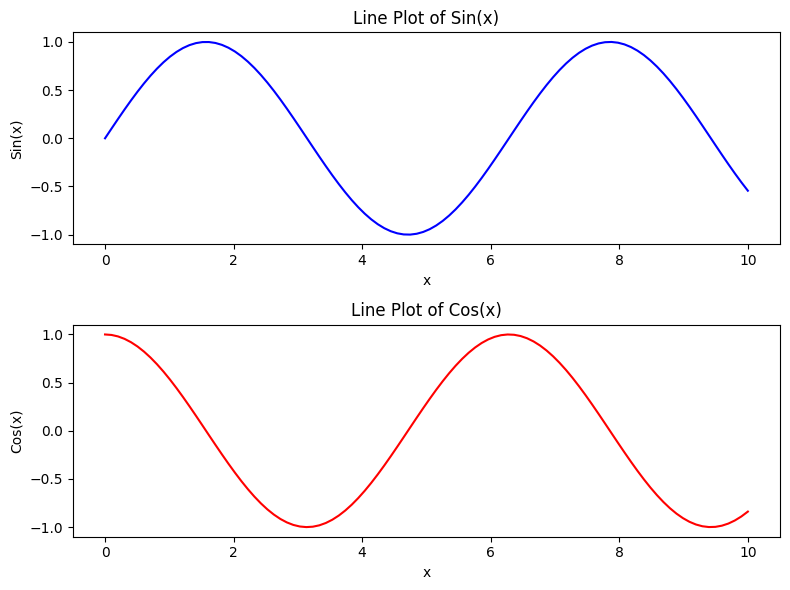

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)

# Create two subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Plot sin(x) in the first subplot
axs[0].plot(x, y1, color='blue')
axs[0].set_title('Line Plot of Sin(x)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('Sin(x)')

# Plot cos(x) in the second subplot
axs[1].plot(x, y2, color='red')
axs[1].set_title('Line Plot of Cos(x)')
axs[1].set_xlabel('x')
axs[1].set_ylabel('Cos(x)')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

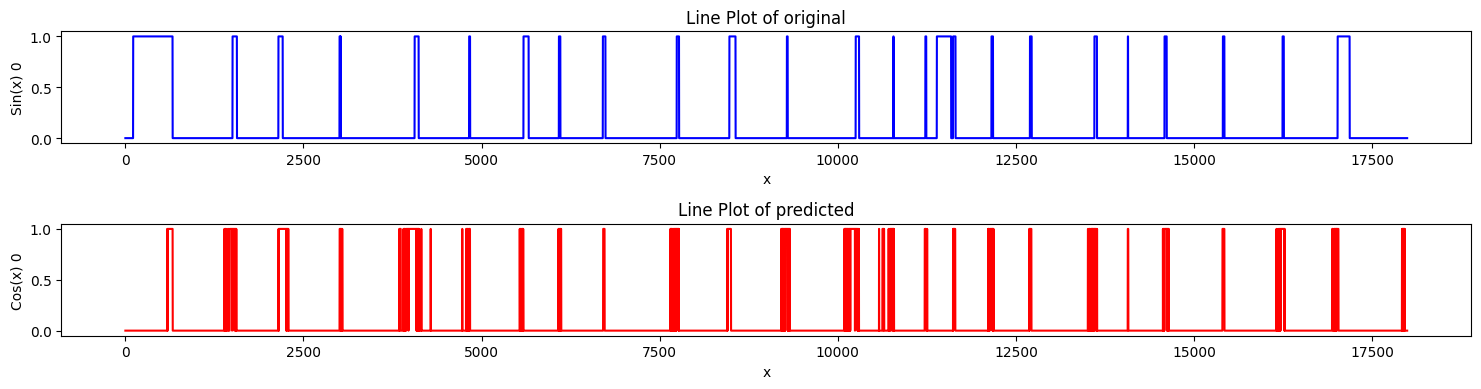

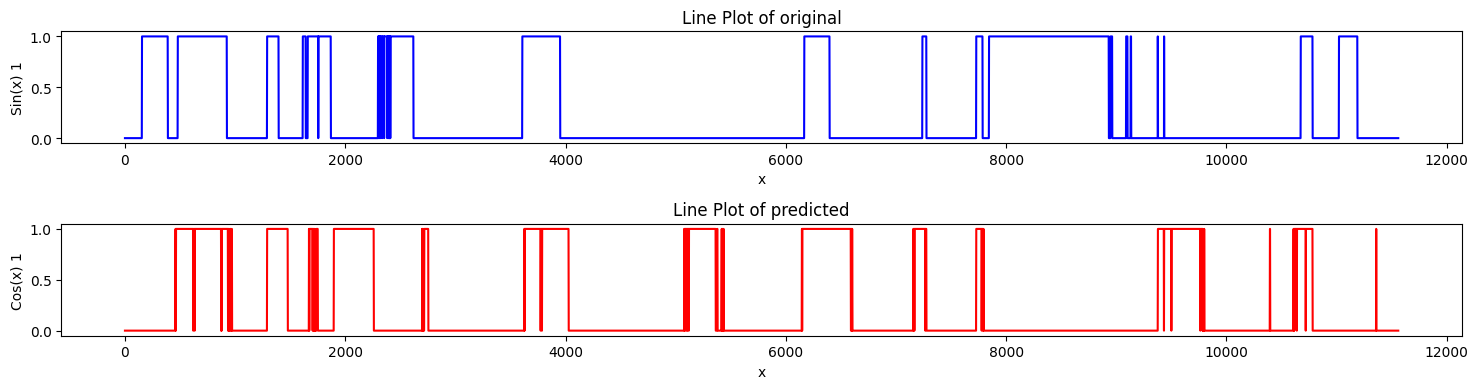

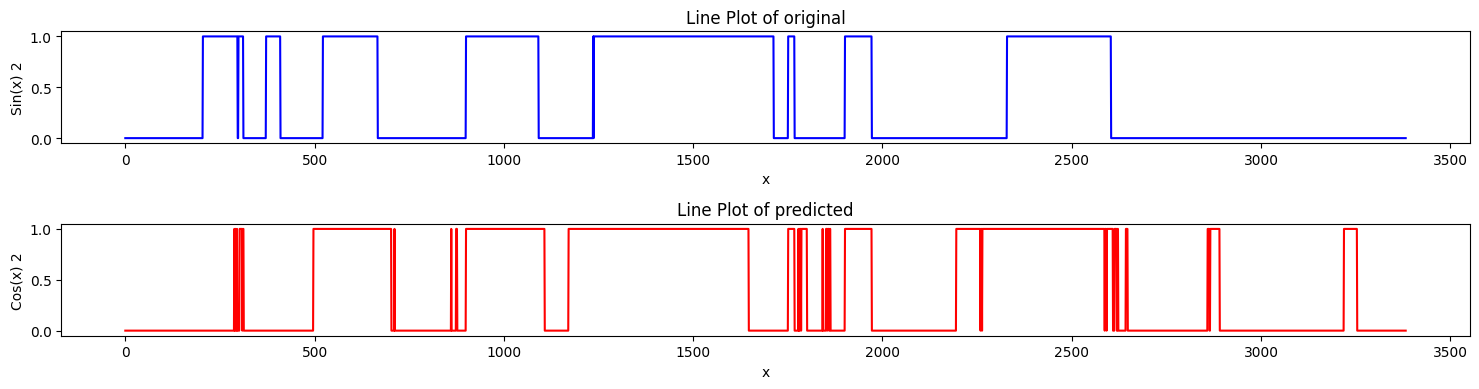

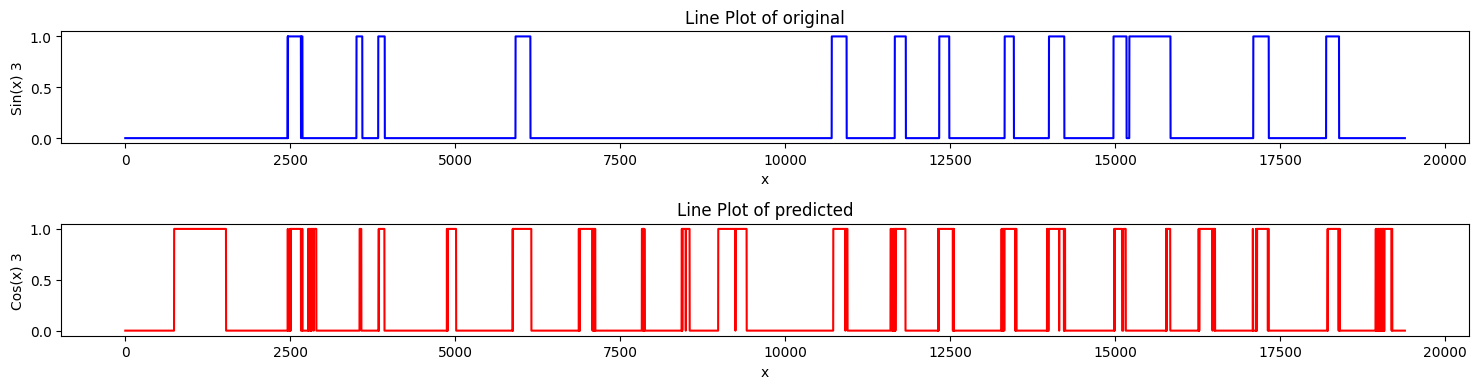

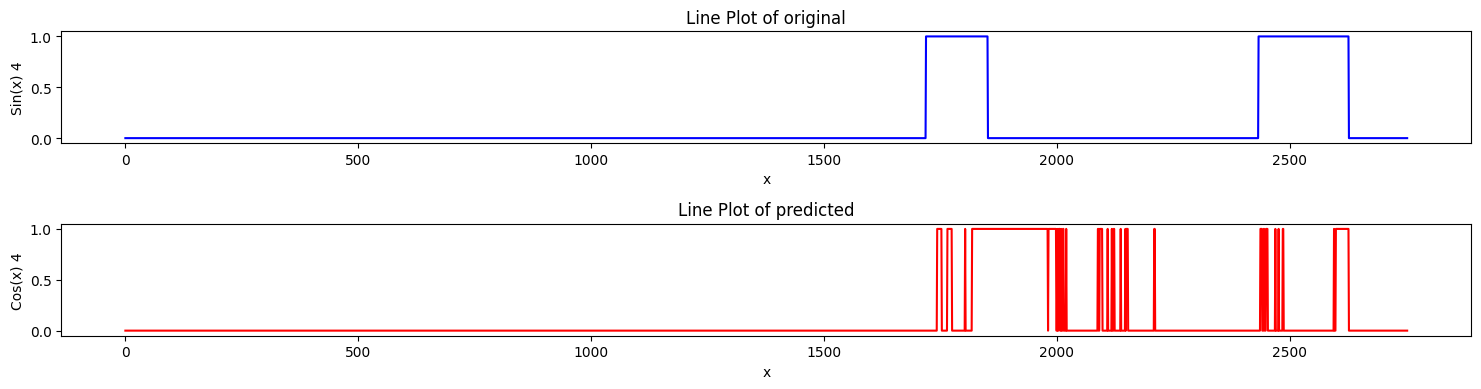

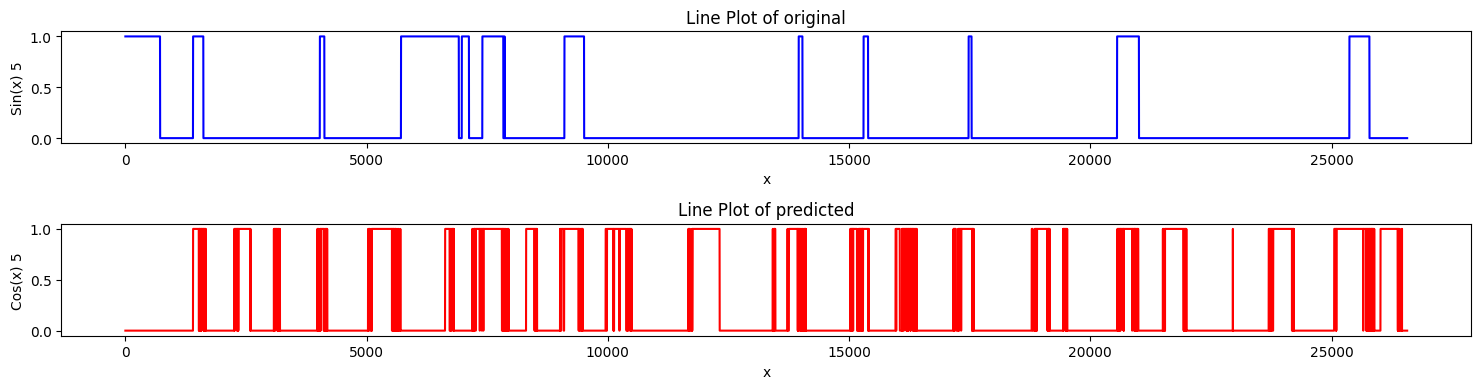

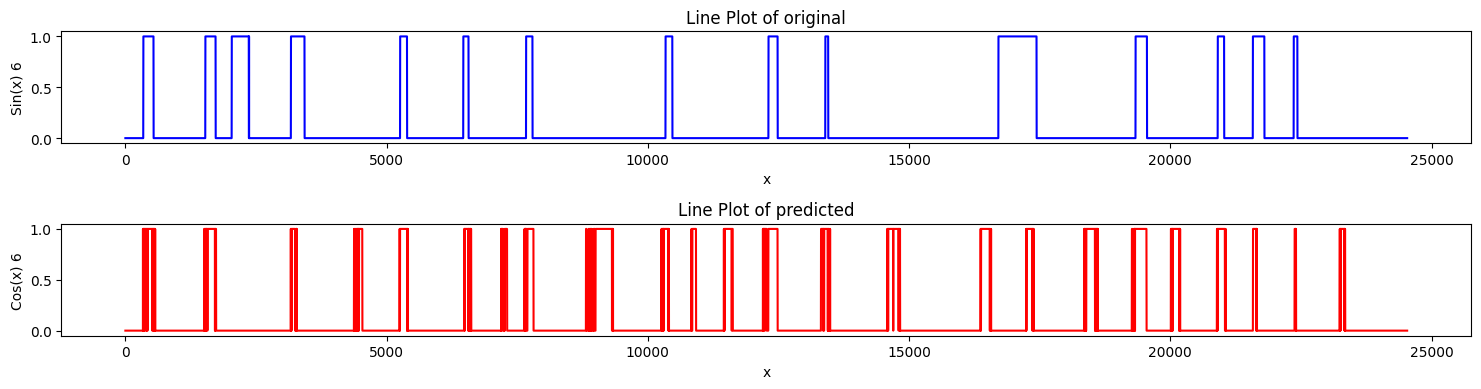

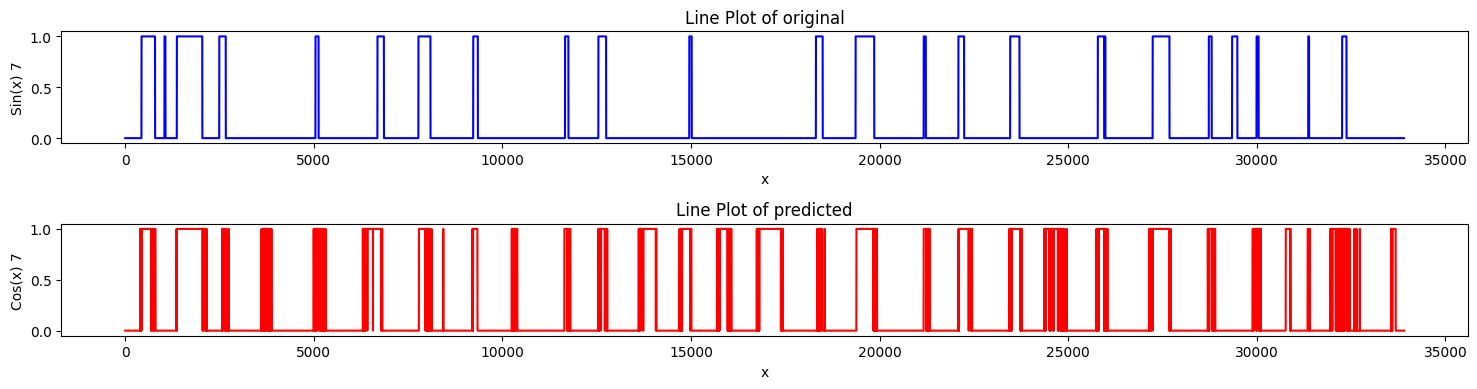

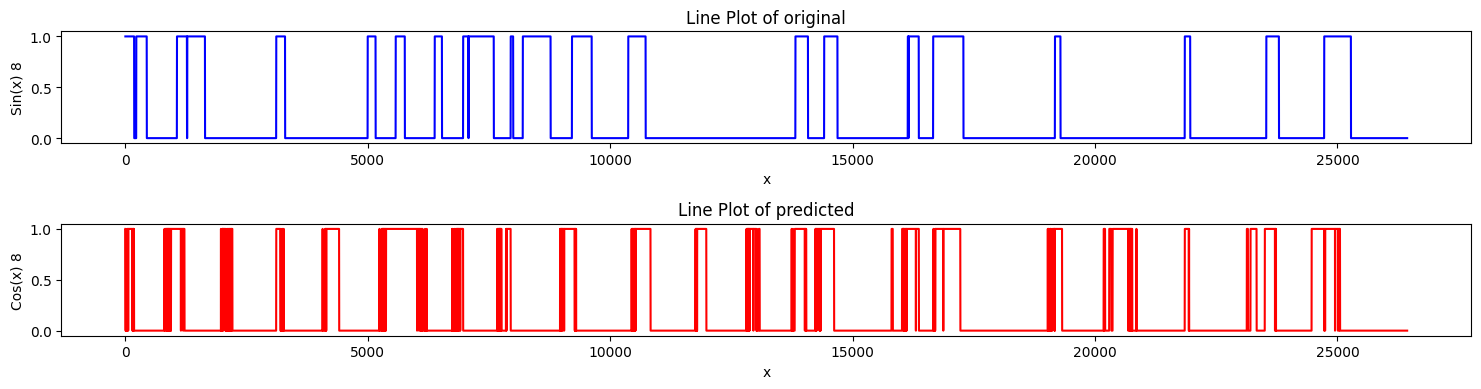

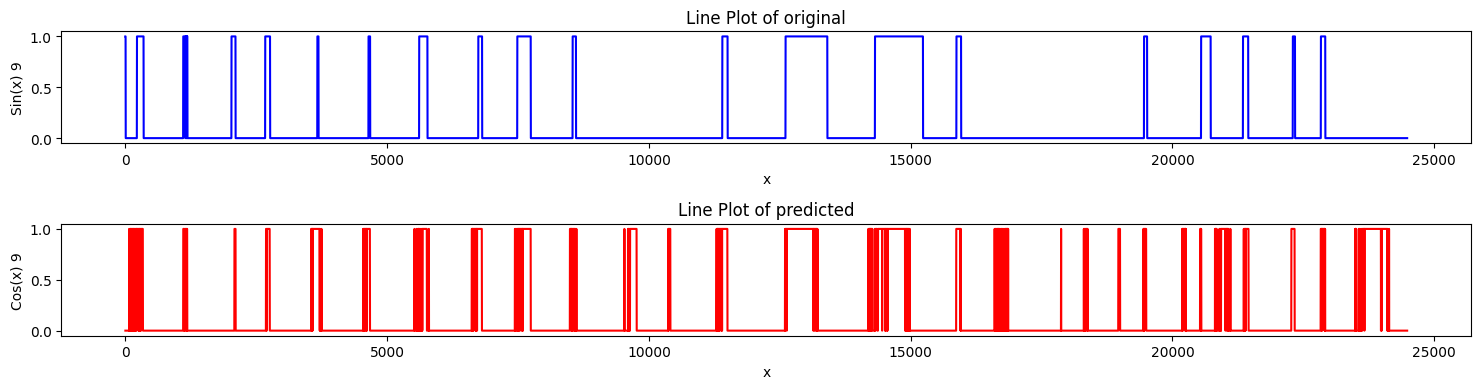

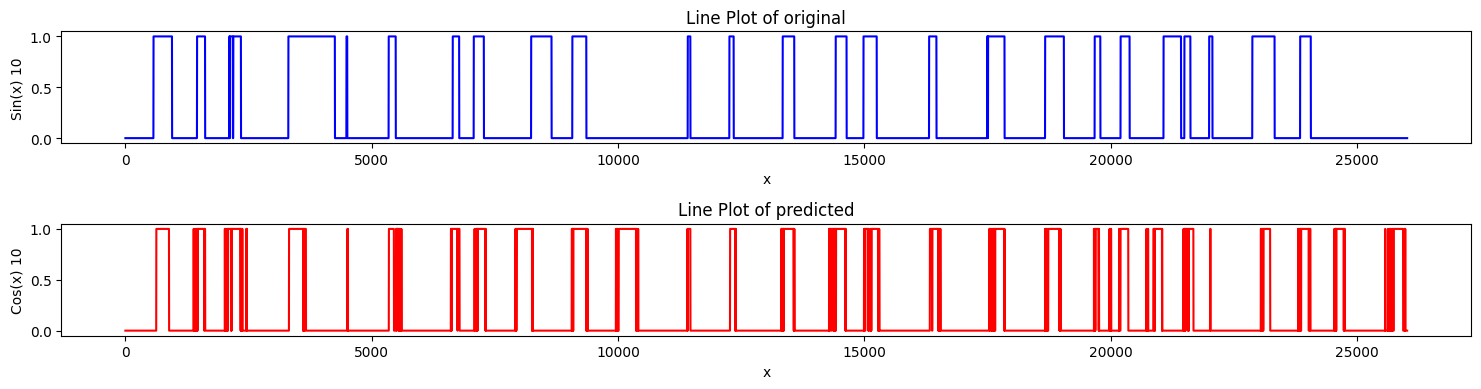

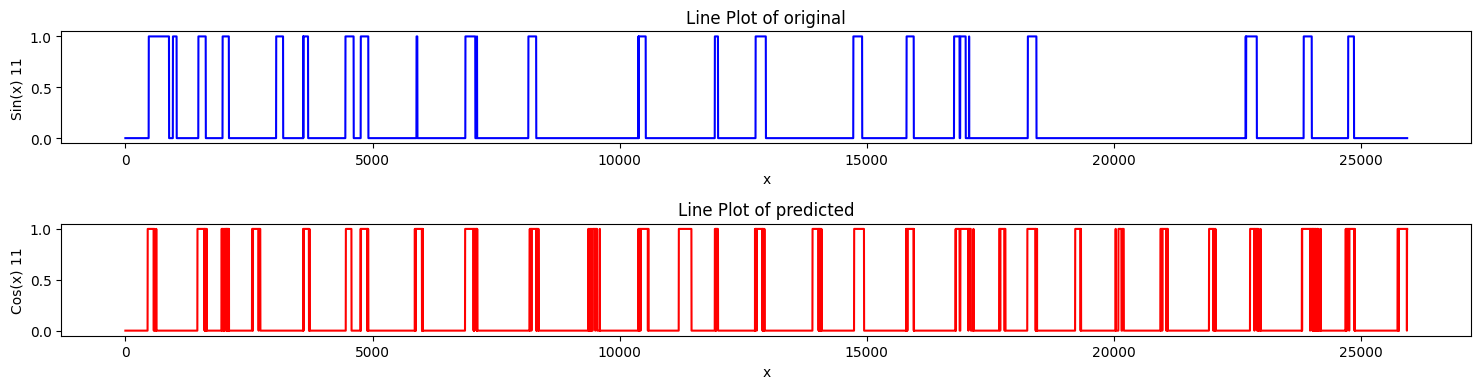

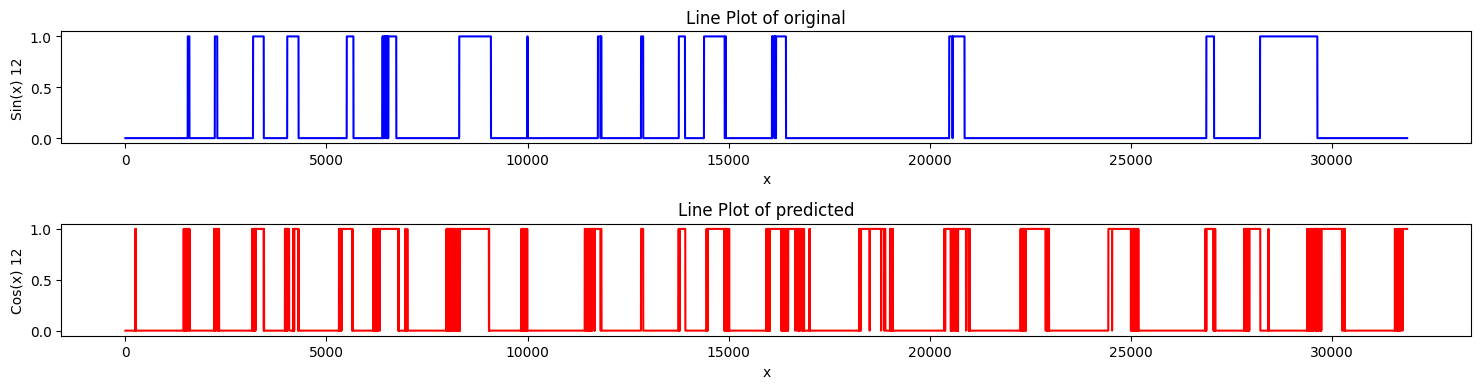

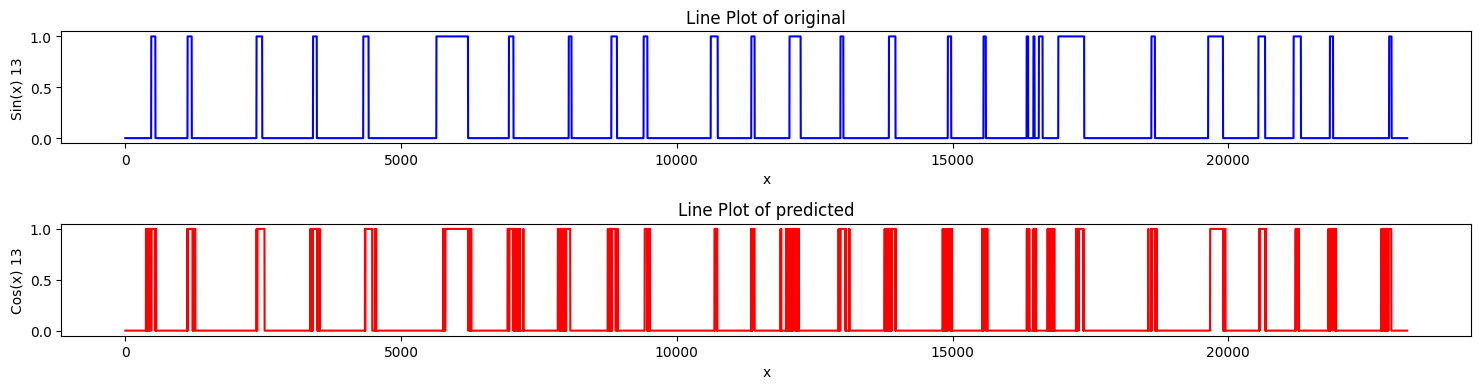

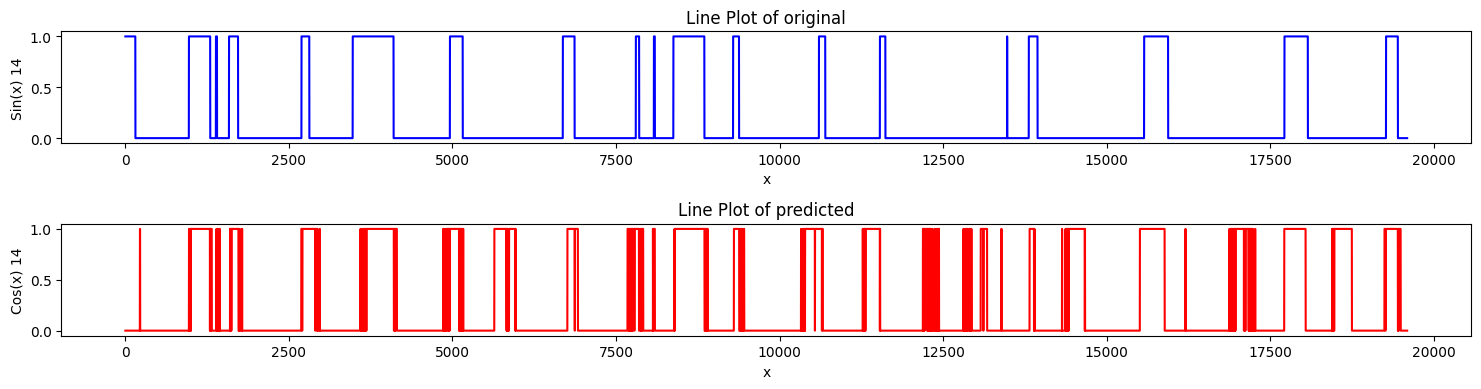

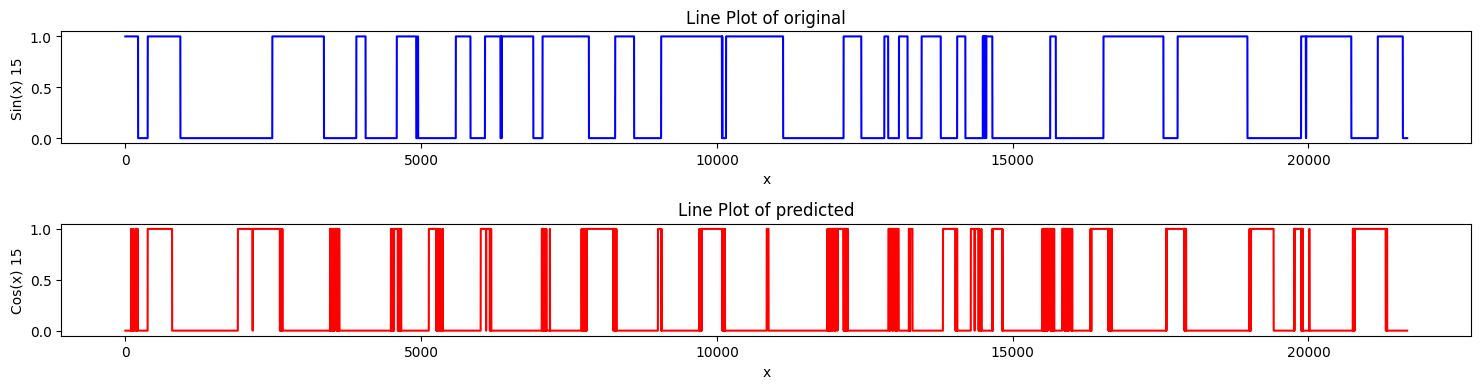

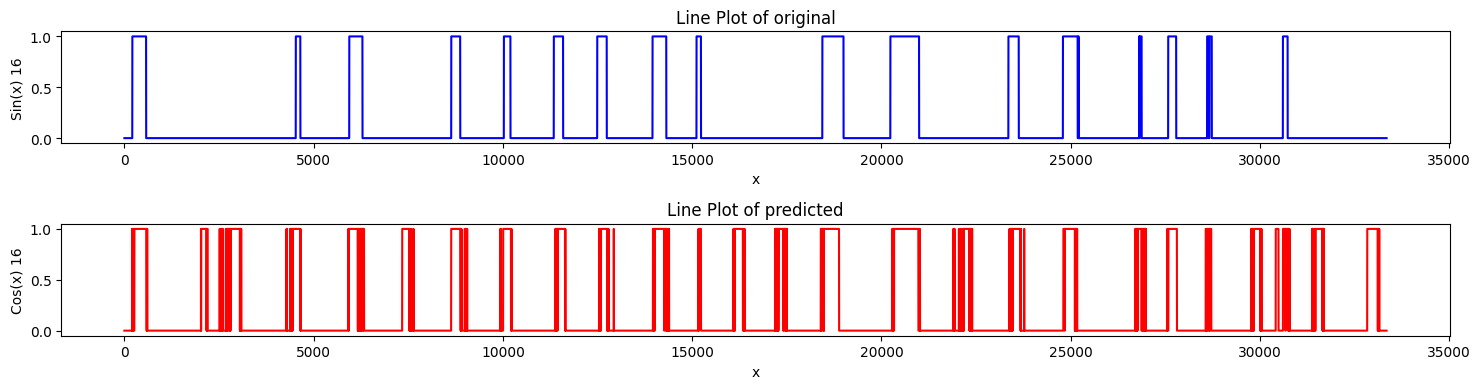

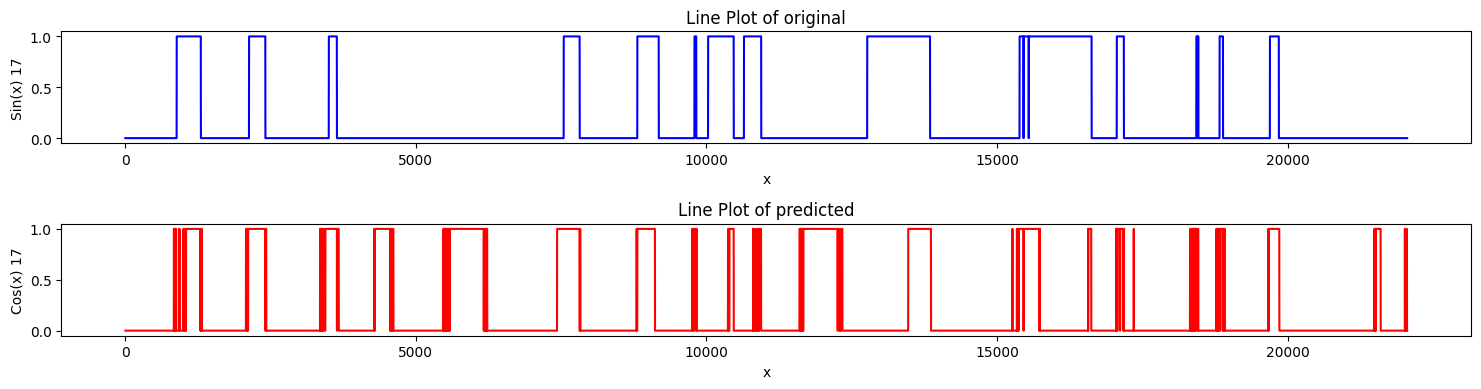

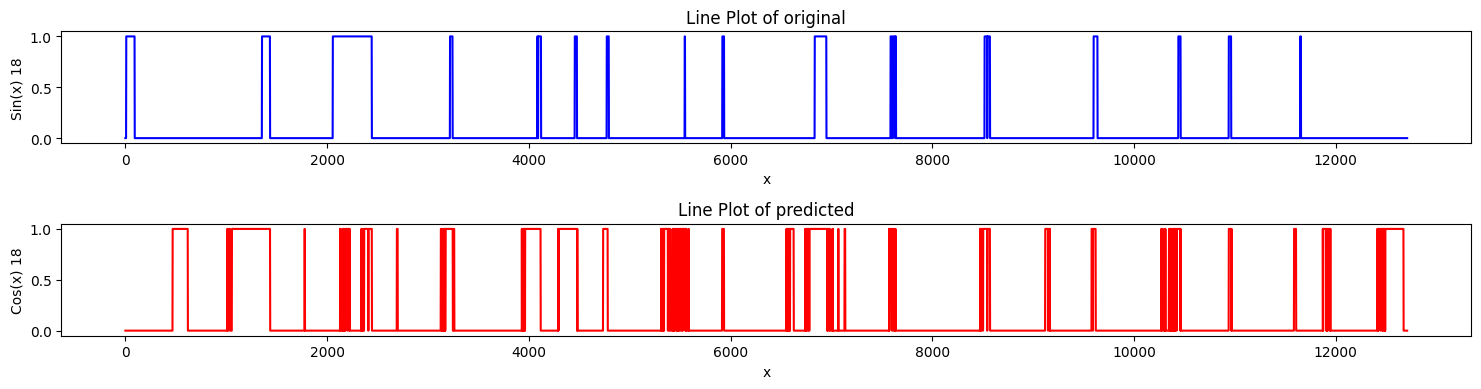

In [21]:

import matplotlib.pyplot as plt
import numpy as np

for i in range(0,len(trainFolders)): 
    trainOne = clientList[i]
    currentFolder = predictedDF[i]

    # Generate some sample data
    #x = np.linspace(0, 10, 100)
    y1 = trainOne["asleep"]
    y2 = currentFolder["asleep"]

    # Create two subplots
    fig, axs = plt.subplots(2, 1, figsize=(15, 4))

    # Plot sin(x) in the first subplot
    axs[0].plot( y1, color='blue')
    axs[0].set_title('Line Plot of original')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('Sin(x) '+str(i))

    # Plot cos(x) in the second subplot
    axs[1].plot( y2, color='red')
    axs[1].set_title('Line Plot of predicted')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('Cos(x) '+str(i))

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()


In [22]:
awakeValues = predictedDF[0]["awake"].tolist()
bkAwakeValues = predictedDF[0]["awake"].tolist()

In [23]:
bkAwakeValues

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [24]:

sizeOftheArray = len(awakeValues)
windowTolerance = 50
i = 0
while i < sizeOftheArray:
    currentValue = awakeValues[i]
    
    nextWindow = i + windowTolerance
    
    if (nextWindow >= sizeOftheArray):
        break;
        
    endValue = awakeValues[nextWindow]
    
    print(i,"Current and end values: ",currentValue, endValue)
    
    if(currentValue == 1 and endValue == 1):
        print("doing stuff")
        for j in range (i, nextWindow):
            awakeValues[j] = currentValue
            
        i = nextWindow
    else:
        i = i + 1
    
#for i in range (0, sizeOftheArray):
#    currentValue = awakeValues[i]
#    
#    nextWindow = i + windowTolerance
#    
#    if (nextWindow >= sizeOftheArray):
#        break;
#        
#    endValue = awakeValues[nextWindow]
#    
#    if(currentValue == 1 and endValue == 1):
#        for j in range (i, nextWindow):
#            awakeValues[j] = currentValue
        

0 Current and end values:  1 1
doing stuff
50 Current and end values:  1 1
doing stuff
100 Current and end values:  1 1
doing stuff
150 Current and end values:  1 1
doing stuff
200 Current and end values:  1 1
doing stuff
250 Current and end values:  1 1
doing stuff
300 Current and end values:  1 1
doing stuff
350 Current and end values:  1 1
doing stuff
400 Current and end values:  1 1
doing stuff
450 Current and end values:  1 1
doing stuff
500 Current and end values:  1 1
doing stuff
550 Current and end values:  1 0
551 Current and end values:  1 0
552 Current and end values:  1 0
553 Current and end values:  1 0
554 Current and end values:  1 0
555 Current and end values:  1 0
556 Current and end values:  1 0
557 Current and end values:  1 0
558 Current and end values:  1 0
559 Current and end values:  1 0
560 Current and end values:  1 0
561 Current and end values:  1 0
562 Current and end values:  1 0
563 Current and end values:  1 0
564 Current and end values:  1 0
565 Current a

In [30]:
clientIndex = 0
column = "asleep"
realValues = clientList[clientIndex]["awake"].tolist()
awakeValues = predictedDF[clientIndex]["awake"].tolist()
bkAwakeValues = predictedDF[clientIndex]["awake"].tolist()

sizeOftheArray = len(awakeValues)
windowTolerance = 30
i = 0
while i < sizeOftheArray:
    currentValue = awakeValues[i]
    
    nextWindow = i + windowTolerance
    
    if (nextWindow >= sizeOftheArray):
        break;
        
    endValue = awakeValues[nextWindow]
    
    #print(i,"Current and end values: ",currentValue, endValue)
    
    if(currentValue == 1 and endValue == 1):
        print("doing stuff")
        count = 0        
        
        for j in range (i, nextWindow):
            if (awakeValues[j] == 1):
                count = count + 1
                
        if(count > (windowTolerance/2)):
            for j in range (i, nextWindow):
                awakeValues[j] = currentValue
            
        i = nextWindow
    else:
        i = i + 1
    

doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doing stuff
doin

In [31]:
len(awakeValues)

17993

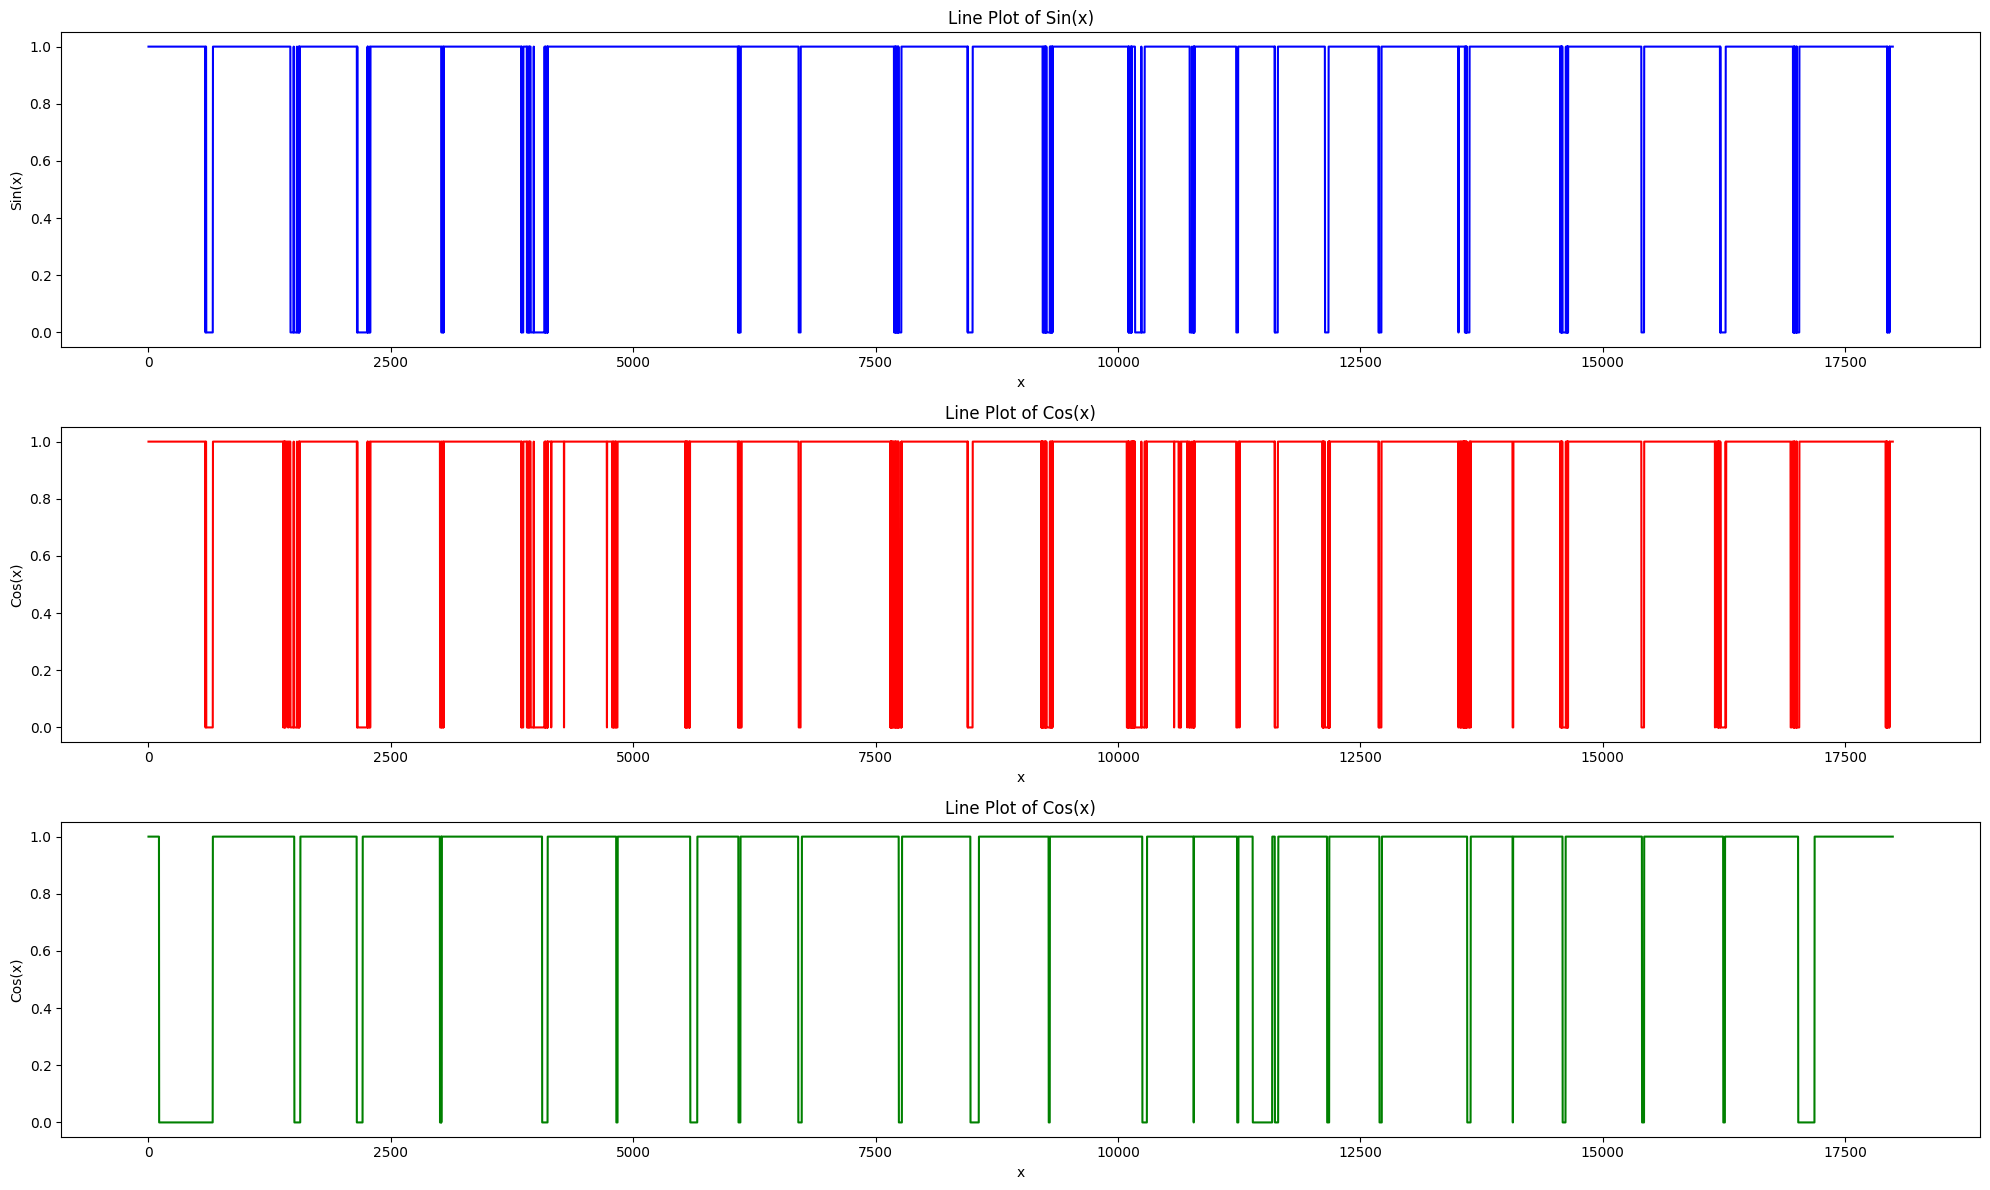

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
#x = np.linspace(0, 10, 100)
y1 = awakeValues
y2 = bkAwakeValues
y3 = realValues

# Create two subplots
fig, axs = plt.subplots(3, 1, figsize=(20, 12))

# Plot sin(x) in the first subplot
axs[0].plot( y1, color='blue')
axs[0].set_title('Line Plot of Sin(x)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('Sin(x)')

# Plot cos(x) in the second subplot
axs[1].plot( y2, color='red')
axs[1].set_title('Line Plot of Cos(x)')
axs[1].set_xlabel('x')
axs[1].set_ylabel('Cos(x)')

# Plot cos(x) in the second subplot
axs[2].plot( y3, color='green')
axs[2].set_title('Line Plot of Cos(x)')
axs[2].set_xlabel('x')
axs[2].set_ylabel('Cos(x)')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [33]:
#y1 = awakeValues
#y2 = bkAwakeValues
#y3 = realValues
dfA = pd.DataFrame(data=awakeValues,columns=["class"])
dfP = pd.DataFrame(data=bkAwakeValues,columns=["class"])
dfR = pd.DataFrame(data=realValues,columns=["class"])
printMetrics(dfA,dfR)

print("--------------")
print("--------------")
print("--------------")
printMetrics(dfP,dfR)


print("--------------")
print("--------------")
print("--------------")
printMetrics(dfP,dfA)

Accuracy: 0.896682
Precision: 0.954715
Recall: 0.933074
F1 score: 0.943771
Cohens kappa: 0.309241
ROC AUC: 0.675885
\Confusion Matrix
[[ 533 740][ 1119 15601]]
--------------
--------------
--------------
Accuracy: 0.887067
Precision: 0.941619
Recall: 0.934528
F1 score: 0.938060
Cohens kappa: 0.299170
ROC AUC: 0.655091
\Confusion Matrix
[[ 574 954][ 1078 15387]]
--------------
--------------
--------------
Accuracy: 0.985828
Precision: 0.984749
Recall: 1.000000
F1 score: 0.992316
Cohens kappa: 0.901346
ROC AUC: 0.916558
\Confusion Matrix
[[ 1273 255][ 0 16465]]


({'accuracy': 0.9858278219307508,
  'precision': 0.9847488038277512,
  'recall': 1.0,
  'f1_score': 0.9923158053337351,
  'cohen_kappa_score': 0.901345905192224,
  'roc_auc_score': 0.9165575916230366,
  'matrix': '[[ 1273 255][ 0 16465]]',
  'TP': 1273,
  'FP': 255,
  'FN': 0,
  'TN': 16465},
 [0.9858278219307508,
  0.9847488038277512,
  1.0,
  0.9923158053337351,
  0.901345905192224,
  0.9165575916230366,
  '[[ 1273 255][ 0 16465]]',
  1273,
  255,
  0,
  16465])

In [35]:
secAwake = 0
secSleep = 0
for t in dfR["class"]:
    if(t == 1):
        if(secSleep > 0):
            segundos = 30*secSleep
            horas = segundos/60
            print("Asleep:",segundos,horas)
            secSleep = 0
        secAwake = secAwake + 1
    else:
        if(secAwake > 0):
            segundos = 30*secAwake
            horas = segundos/60
            print("Awake: ",segundos,horas)
            secAwake = 0
        secSleep = secSleep + 1

Awake:  3270 54.5
Asleep: 16620 277.0
Awake:  25230 420.5
Asleep: 1860 31.0
Awake:  17460 291.0
Asleep: 1830 30.5
Awake:  23910 398.5
Asleep: 390 6.5
Awake:  30 0.5
Asleep: 30 0.5
Awake:  31170 519.5
Asleep: 1710 28.5
Awake:  21240 354.0
Asleep: 420 7.0
Awake:  22470 374.5
Asleep: 2190 36.5
Awake:  12720 212.0
Asleep: 630 10.5
Awake:  17880 298.0
Asleep: 1110 18.5
Awake:  30000 500.0
Asleep: 990 16.5
Awake:  21180 353.0
Asleep: 2610 43.5
Awake:  21600 360.0
Asleep: 360 6.0
Awake:  28620 477.0
Asleep: 1440 24.0
Awake:  14430 240.5
Asleep: 90 1.5
Awake:  13380 223.0
Asleep: 390 6.5
Awake:  4440 74.0
Asleep: 6030 100.5
Awake:  810 13.5
Asleep: 1050 17.5
Awake:  15120 252.0
Asleep: 660 11.0
Awake:  15540 259.0
Asleep: 750 12.5
Awake:  26400 440.0
Asleep: 1080 18.0
Awake:  12990 216.5
Asleep: 120 2.0
Awake:  15330 255.5
Asleep: 930 15.5
Awake:  23640 394.0
Asleep: 660 11.0
Awake:  24480 408.0
Asleep: 540 9.0
Awake:  22650 377.5
Asleep: 5070 84.5
